In [62]:
import matplotlib.pyplot as plt
import numpy as np 

from mne import Epochs, pick_types, events_from_annotations, read_epochs, concatenate_raws
from mne_nirs.signal_enhancement import enhance_negative_correlation
from mne.io import read_raw_nirx, RawArray
from mne.preprocessing import ICA
from mne.viz import plot_compare_evokeds
from itertools import compress
from mne.preprocessing.nirs import beer_lambert_law, scalp_coupling_index, source_detector_distances, optical_density
from jupyterthemes.stylefx import set_nb_theme
set_nb_theme('gruvboxd')

In [63]:
event_dict = {'left': 1, 'right': 2, 'r_pinch': 3, 'rest': 4, 'r_stop': 5}

In [64]:
raw = read_raw_nirx('nirs')
raw_od = optical_density(raw)

Loading nirs


C:\Users\Alberto\AppData\Local\Temp\ipykernel_17928\2156314533.py:1: RuntimeWarning: Extraction of measurement date from NIRX file failed. This can be caused by files saved in certain locales (currently only ['en_US.utf8', 'de_DE', 'fr_FR', 'it_IT'] supported). Please report this as a github issue. The date is being set to January 1st, 2000, instead of '"12 Dec 2022""16:41:45.096"'.
  raw = read_raw_nirx('nirs')


Reading 0 ... 20198  =      0.000 ...  2585.344 secs...


Compute Scalp Coupling

In [65]:
sci = scalp_coupling_index(raw_od)
fig, ax = plt.subplots()
ax.hist(sci)
ax.set(xlabel='Scalp Coupling Index', ylabel='Count', xlim=[0, 1])

[Text(0.5, 0, 'Scalp Coupling Index'), Text(0, 0.5, 'Count'), (0.0, 1.0)]

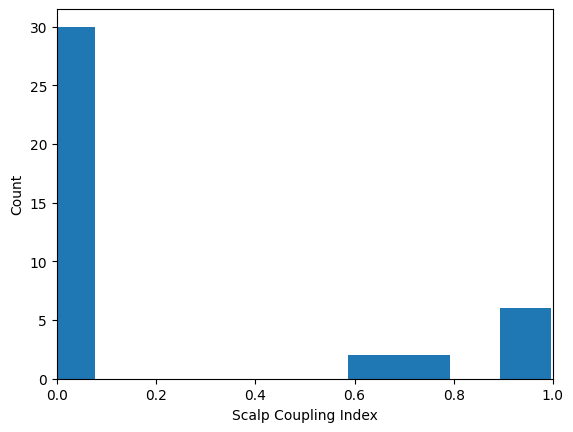

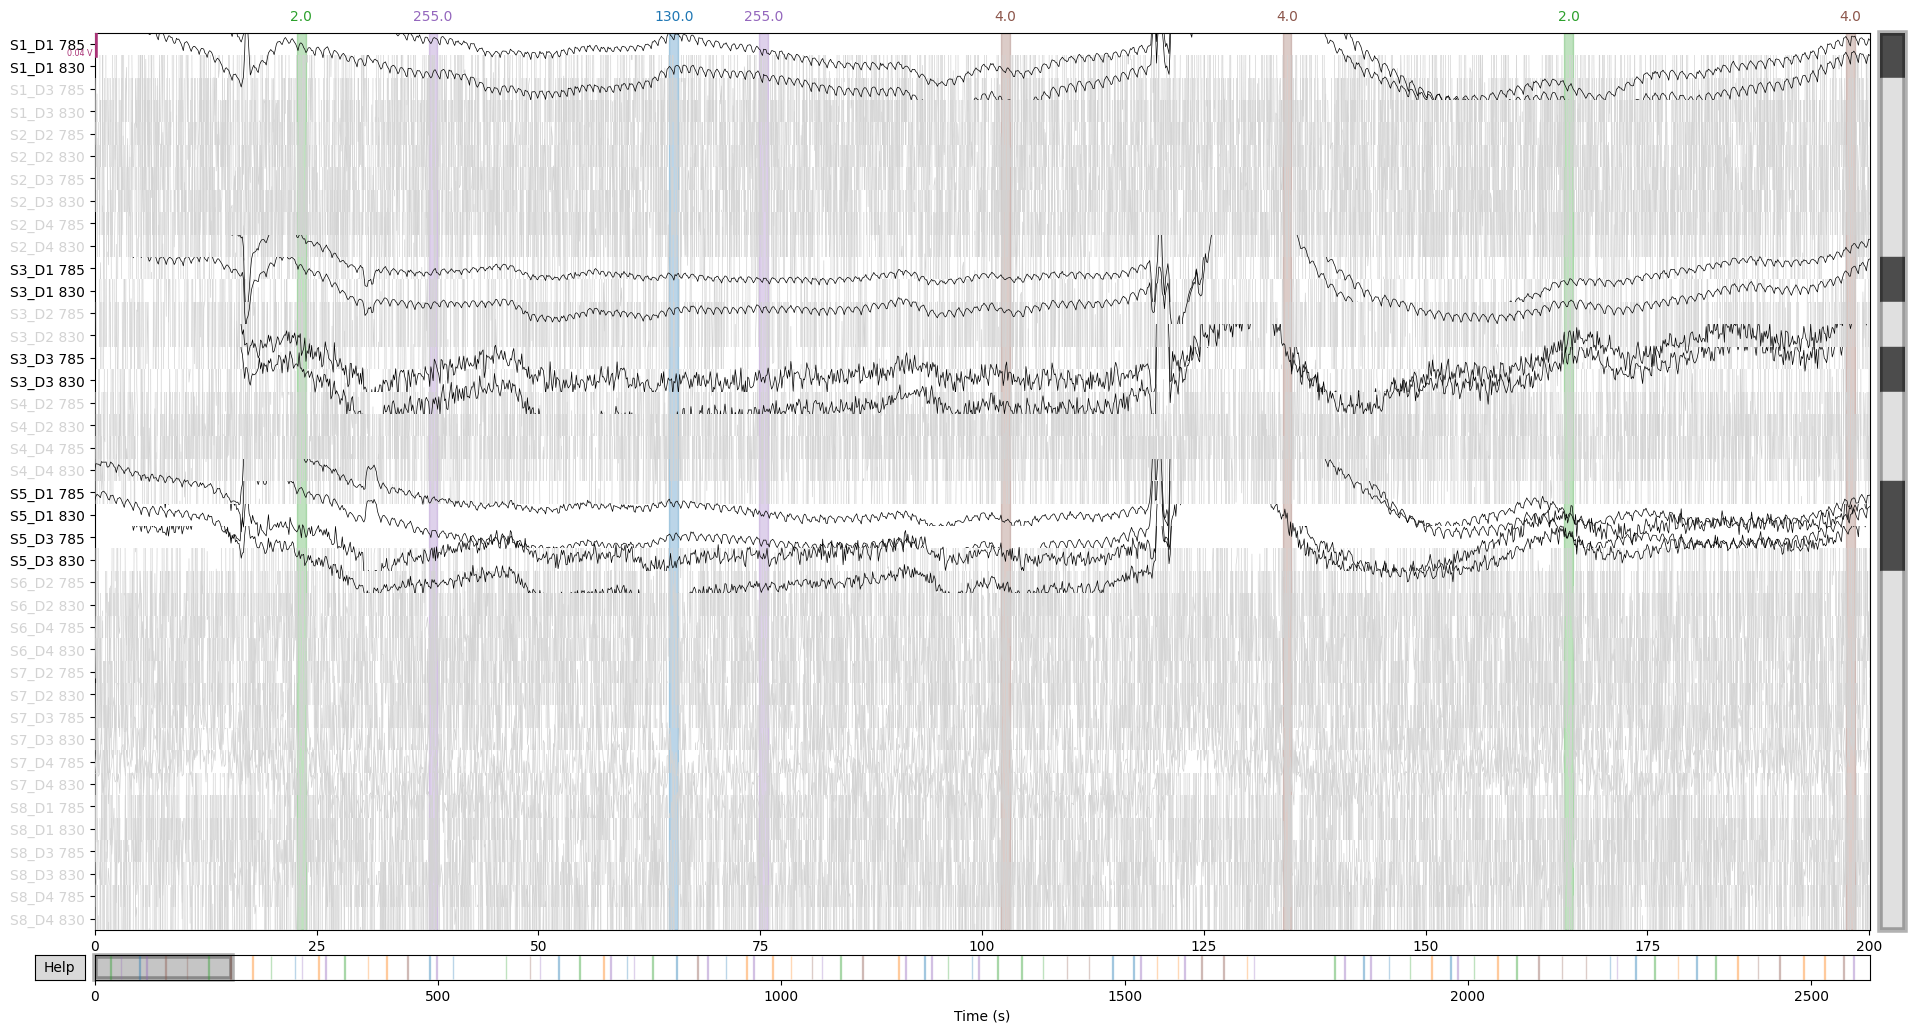

In [66]:
raw_od.info['bads'] = list(compress(raw_od.ch_names, sci < 0.6))
raw_od.plot(n_channels=40, duration=200)
print()

Compute Haemoglobin 

In [67]:
raw_hmo = beer_lambert_law(raw_od, ppf=0.1)
raw_corr = enhance_negative_correlation(raw_hmo) 


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 32.768 (s)


C:\Users\Alberto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


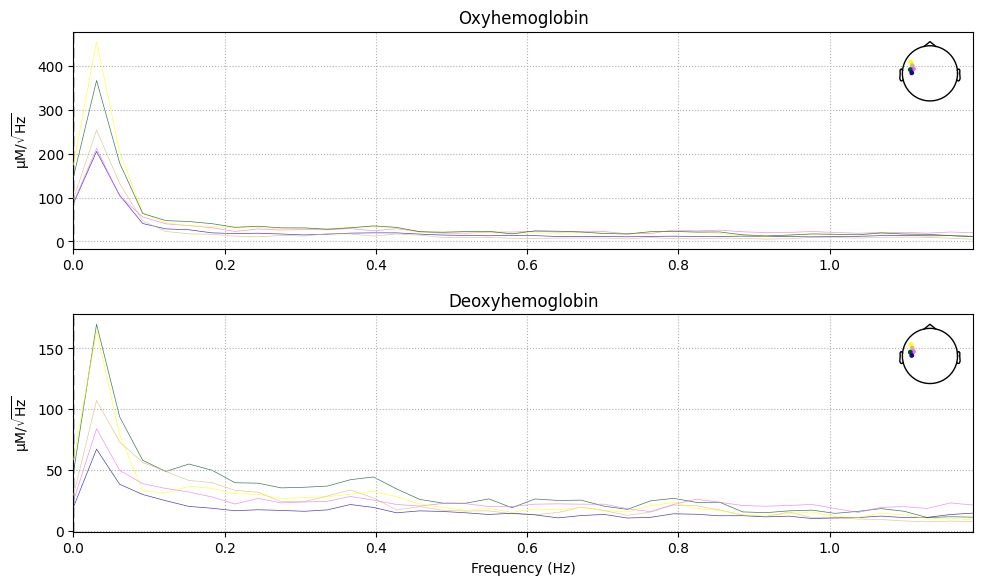

In [68]:
print()
raw_hmo.plot_psd(average=False, dB=False, tmax=1200 ,fmax=1.2)

Bandpass filter

In [69]:
print()
raw_hmo = raw_hmo.filter(0.05, 0.7, h_trans_bandwidth=0.2, l_trans_bandwidth=0.02, n_jobs=8)
raw_corr = raw_corr.filter(0.05, 0.7, h_trans_bandwidth=0.2, l_trans_bandwidth=0.02, n_jobs=8)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1291 samples (165.248 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passb

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:    0.0s finished


In [70]:
event, event_id = events_from_annotations(raw_hmo)
epochs = Epochs(raw_hmo, event, event_id=event_dict,
        tmin=-5, tmax=20,
        proj=True, preload=True,
        detrend=None, verbose=True)
epochs.save('nirs_epo.fif', overwrite=True)

evoked_dict = {'imagery/HbO': epochs['left','right'].average(picks='hbo'),
               'imagery/HbR': epochs['left','right'].average(picks='hbr'),
               'rest/HbO': epochs['rest'].average(picks='hbo'),
               'rest/HbR': epochs['rest'].average(picks='hbr')}

epochs_corr = Epochs(raw_corr, event, event_id=event_dict,
        tmin=-5, tmax=20,
        proj=True, preload=True,
        detrend=None, verbose=True)
epochs_corr.save('nirs_corr_epo.fif', overwrite=True)

evoked_dict_corr = {'imagery/HbO': epochs_corr['left','right'].average(picks='hbo'),
               'imagery/HbR': epochs_corr['left','right'].average(picks='hbr'),
               'rest/HbO': epochs_corr['rest'].average(picks='hbo'),
               'rest/HbR': epochs_corr['rest'].average(picks='hbr')}

for condition in evoked_dict:
    evoked_dict[condition].rename_channels(lambda x: x[:-4])
for condition in evoked_dict_corr:
    evoked_dict_corr[condition].rename_channels(lambda x: x[:-4])
    

del raw_hmo
del raw_od

Used Annotations descriptions: ['130.0', '134.0', '2.0', '255.0', '4.0']
Not setting metadata
94 matching events found
Setting baseline interval to [-4.992, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 94 events and 196 original time points ...
0 bad epochs dropped
Overwriting existing file.
Not setting metadata
94 matching events found
Setting baseline interval to [-4.992, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 94 events and 196 original time points ...
0 bad epochs dropped
Overwriting existing file.


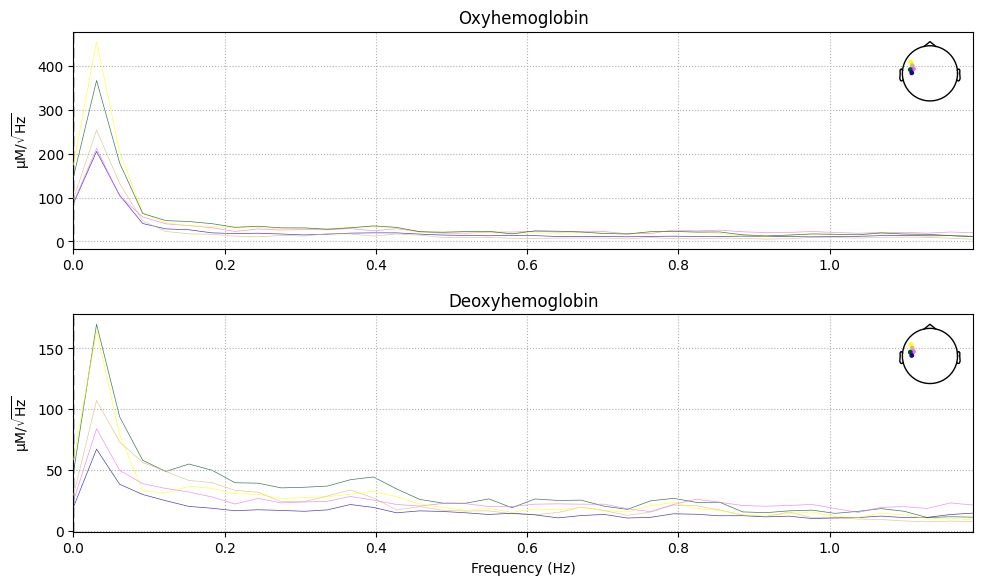

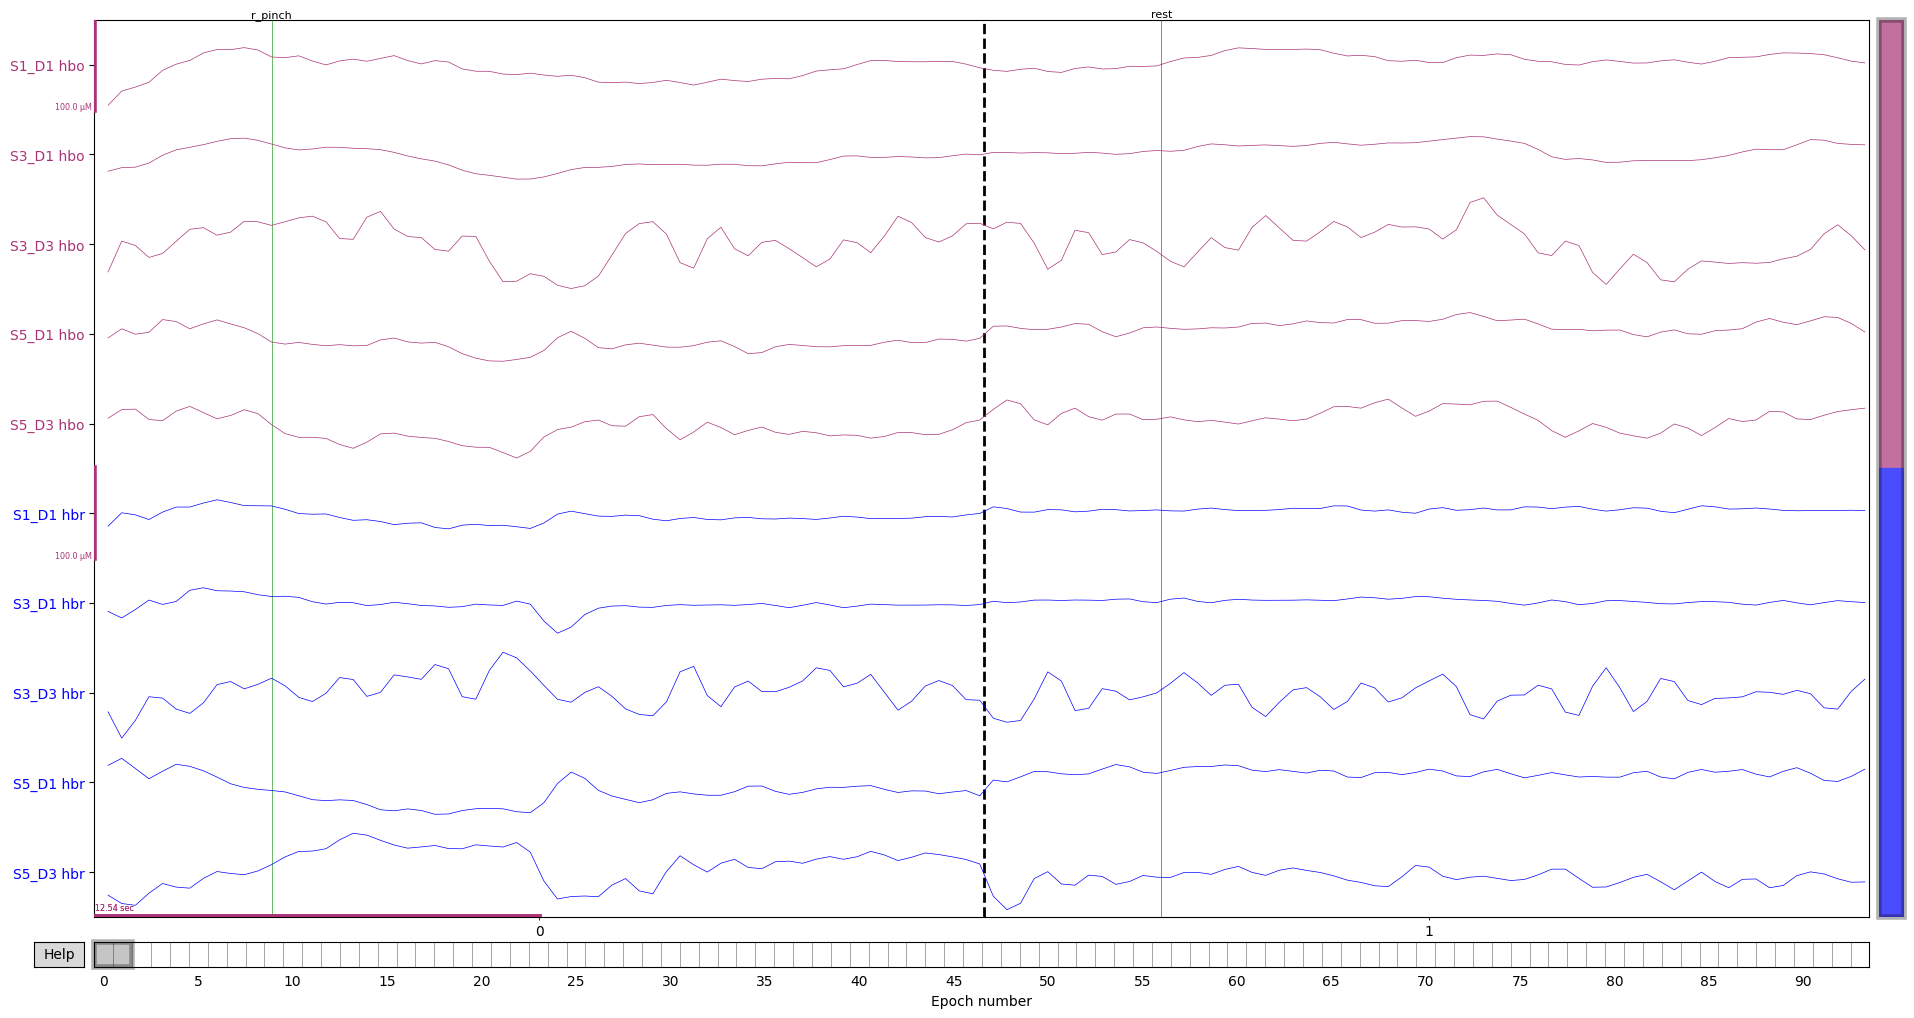

In [71]:
epochs.plot(n_epochs=2, n_channels=20, scalings=50e-6, events=epochs.events, event_id=epochs.event_id)
print()

Removing Artifacts

In [72]:
epochs = read_epochs('nirs_epo.fif')
epochs.drop([87])

Reading C:\Users\Alberto\Documents\BCI\data\kmh\nirs_epo.fif ...
    Found the data of interest:
        t =   -4992.00 ...   19968.00 ms
        0 CTF compensation matrices available
Not setting metadata
94 matching events found
No baseline correction applied
0 projection items activated
Dropped 1 epoch: 87


Number of events,93
Events,left: 18r_pinch: 18r_stop: 18rest: 22right: 17
Time range,-4.992 – 19.968 sec
Baseline,-4.992 – 0.000 sec


Enhacing with Correlation

combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


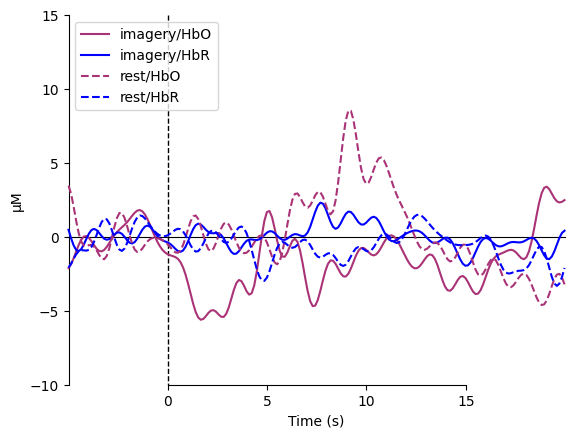

In [73]:
fig, axes = plt.subplots()
color_dict = dict(HbO='#AA3377', HbR='b')
styles_dict = dict(rest=dict(linestyle='dashed'))
plot_compare_evokeds(evoked_dict, combine="mean", ci=0.95,
                             axes=axes, colors=color_dict,
                             styles=styles_dict,
                             ylim=dict(hbo=[-10, 15]))
print()

combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


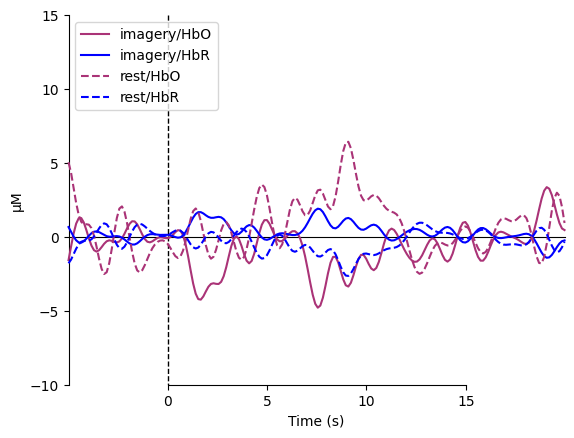

In [74]:
fig, axes = plt.subplots()
plot_compare_evokeds(evoked_dict_corr, combine="mean", ci=0.95,
                             axes=axes, colors=color_dict,
                             styles=styles_dict,
                             ylim=dict(hbo=[-10, 15]))
print()

ICA

In [75]:
hbo = epochs.copy().pick(['hbo'])
hbr = epochs.copy().pick(['hbr'])
del epochs

Fitting ICA to data using 5 channels (please be patient, this may take a while)
Selecting by number: 4 components
Fitting ICA took 0.1s.


C:\Users\Alberto\AppData\Local\Temp\ipykernel_17928\3071247641.py:2: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(hbo)
C:\Users\Alberto\AppData\Local\Temp\ipykernel_17928\3071247641.py:4: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.epochs.EpochsFIF'>.tmax (19.968 sec)
  hbo.copy().crop(0,20),


    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
93 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
93 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
93 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
93 matching events found
No baseline correction applied
0 projection items activated


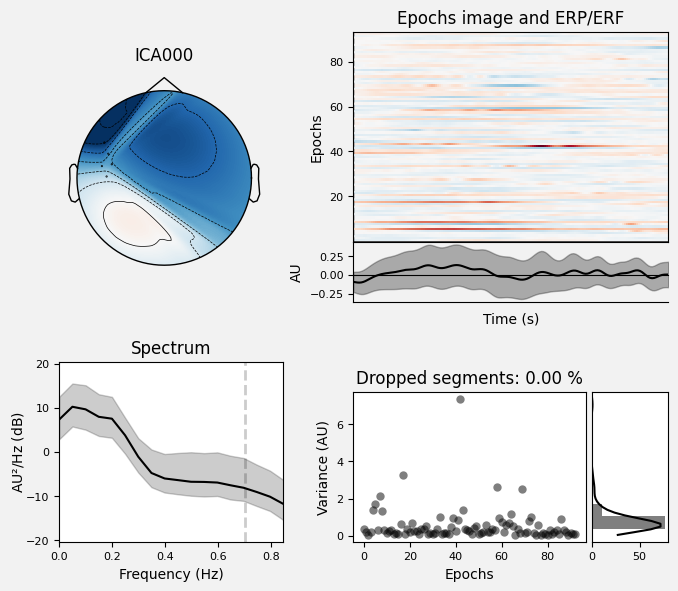

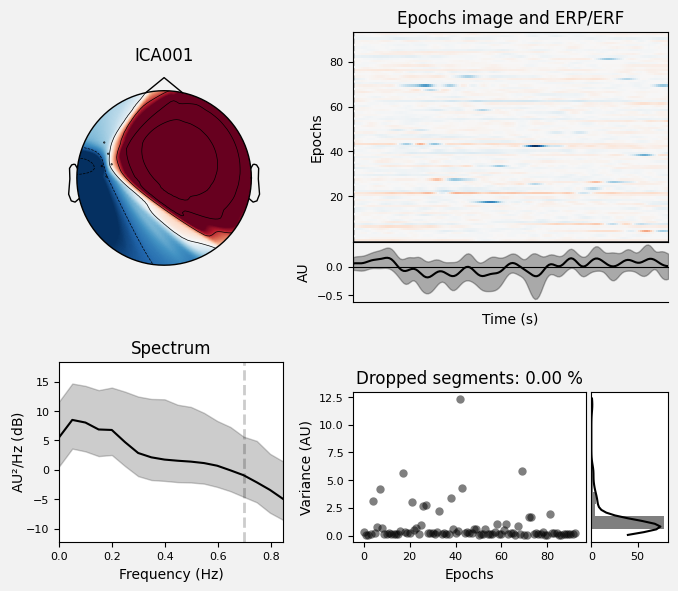

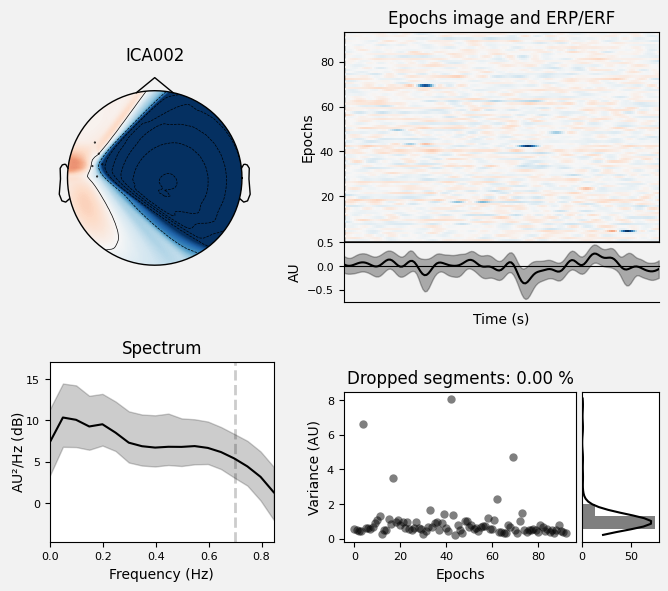

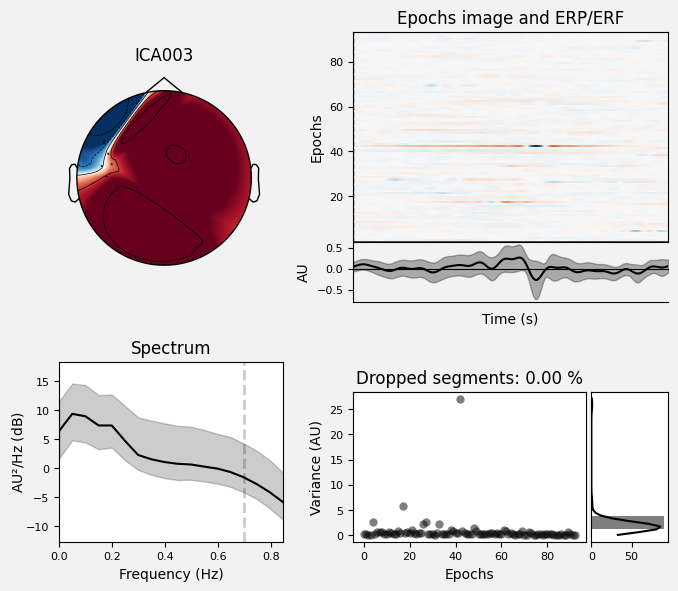

In [76]:
ica = ICA(n_components=4)
ica.fit(hbo)
ica.plot_properties(
    hbo.copy().crop(0,20), 
    picks = [0,1,2,3], 
    log_scale = False)
print()

In [77]:
ica.apply(hbo, exclude=[1])

Applying ICA to Epochs instance
    Transforming to ICA space (4 components)
    Zeroing out 1 ICA component
    Projecting back using 5 PCA components


C:\Users\Alberto\AppData\Local\Temp\ipykernel_17928\3033373089.py:1: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  ica.apply(hbo, exclude=[1])


Number of events,93
Events,left: 18r_pinch: 18r_stop: 18rest: 22right: 17
Time range,-4.992 – 19.968 sec
Baseline,-4.992 – 0.000 sec


Fitting ICA to data using 5 channels (please be patient, this may take a while)
Selecting by number: 4 components
Fitting ICA took 0.1s.


C:\Users\Alberto\AppData\Local\Temp\ipykernel_17928\1871673388.py:1: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(hbr)
C:\Users\Alberto\AppData\Local\Temp\ipykernel_17928\1871673388.py:3: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.epochs.EpochsFIF'>.tmax (19.968 sec)
  hbr.copy().crop(0,20),


    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
93 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
93 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
93 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
93 matching events found
No baseline correction applied
0 projection items activated


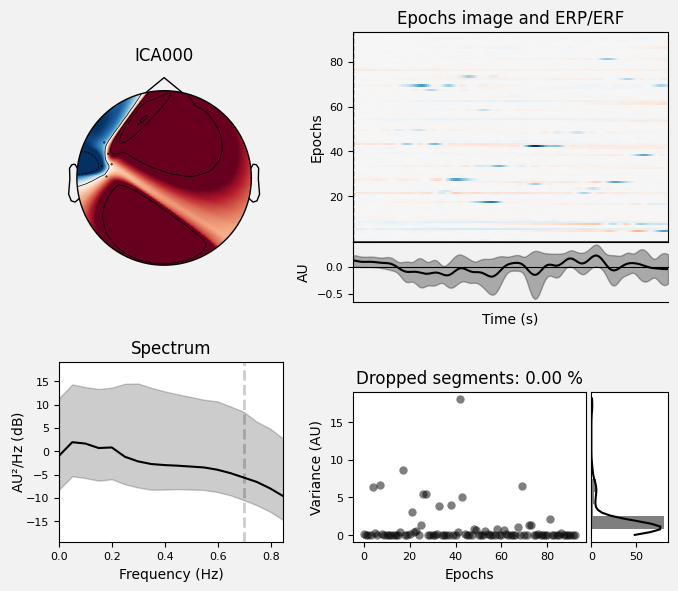

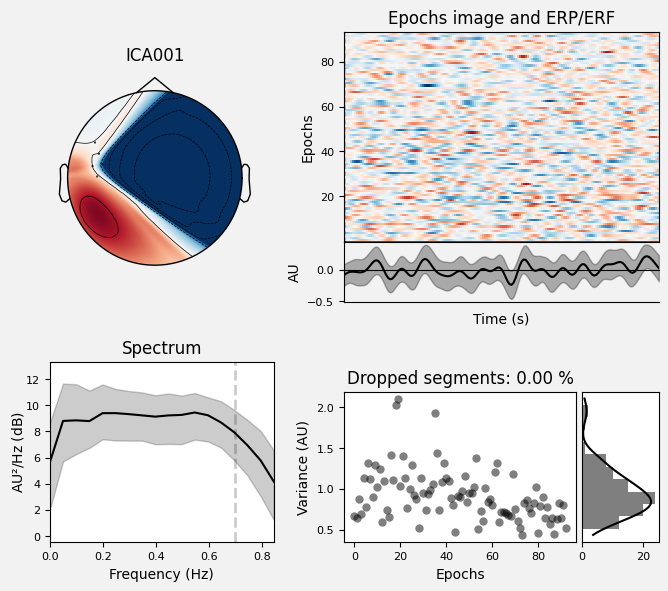

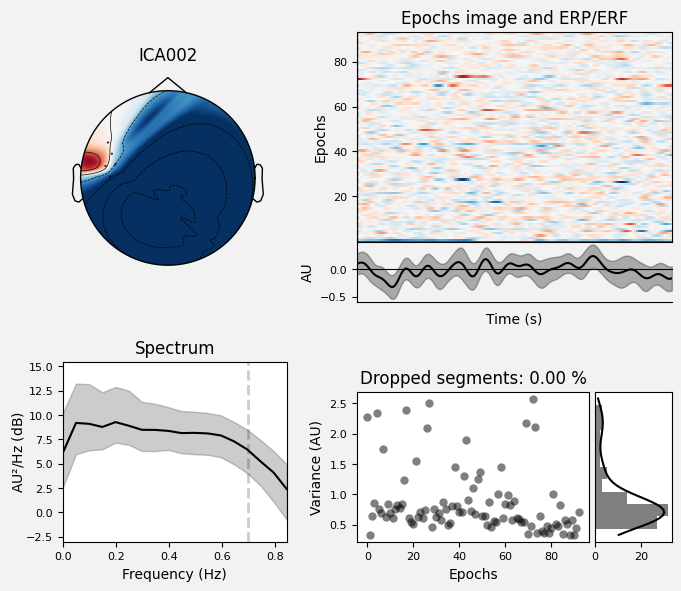

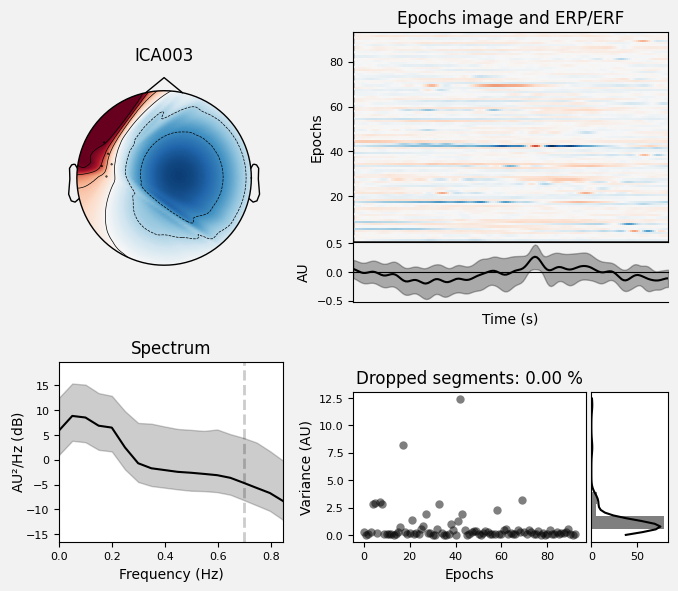

In [78]:
ica.fit(hbr)
ica.plot_properties(
    hbr.copy().crop(0,20), 
    picks = [0,1,2,3], 
    log_scale = False)
print()

In [79]:
ica.apply(hbr, exclude=[0,1])

Applying ICA to Epochs instance
    Transforming to ICA space (4 components)
    Zeroing out 2 ICA components
    Projecting back using 5 PCA components


C:\Users\Alberto\AppData\Local\Temp\ipykernel_17928\2599633736.py:1: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  ica.apply(hbr, exclude=[0,1])


Number of events,93
Events,left: 18r_pinch: 18r_stop: 18rest: 22right: 17
Time range,-4.992 – 19.968 sec
Baseline,-4.992 – 0.000 sec


Not setting metadata
35 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


C:\Users\Alberto\AppData\Local\Temp\ipykernel_17928\1853386071.py:1: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.epochs.EpochsFIF'>.tmax (19.968 sec)
  hbo['left','right'].copy().crop(-3,20).plot_image(combine='mean', vmin=-30, vmax=30,


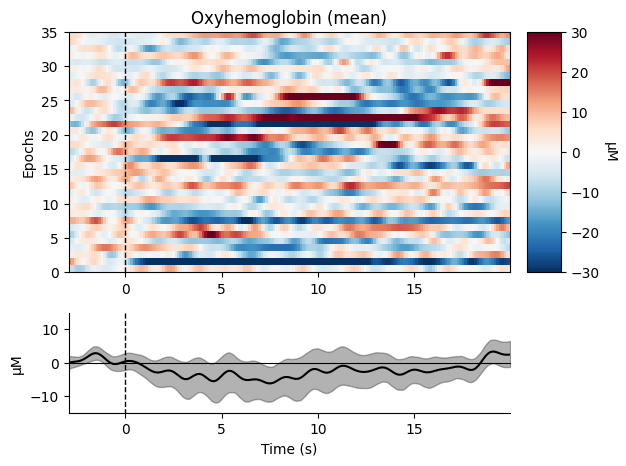

[<Figure size 640x480 with 3 Axes>]

In [80]:
hbo['left','right'].copy().crop(-3,20).plot_image(combine='mean', vmin=-30, vmax=30,
                             ts_args=dict(ylim=dict(hbo=[-15, 15],
                                                    hbr=[-15, 15])))

Not setting metadata
35 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


C:\Users\Alberto\AppData\Local\Temp\ipykernel_17928\1168623161.py:1: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.epochs.EpochsFIF'>.tmax (19.968 sec)
  hbr['left','right'].copy().crop(-3,20).plot_image(combine='mean', vmin=-30, vmax=30,


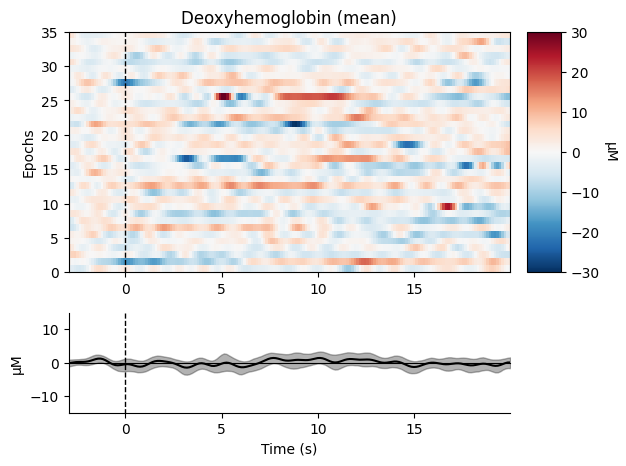

[<Figure size 640x480 with 3 Axes>]

In [81]:
hbr['left','right'].copy().crop(-3,20).plot_image(combine='mean', vmin=-30, vmax=30,
                             ts_args=dict(ylim=dict(hbo=[-15, 15],
                                                    hbr=[-15, 15])))

Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


C:\Users\Alberto\AppData\Local\Temp\ipykernel_17928\757481655.py:1: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.epochs.EpochsFIF'>.tmax (19.968 sec)
  hbo['rest'].copy().crop(-3,20).plot_image(combine='mean', vmin=-30, vmax=30,


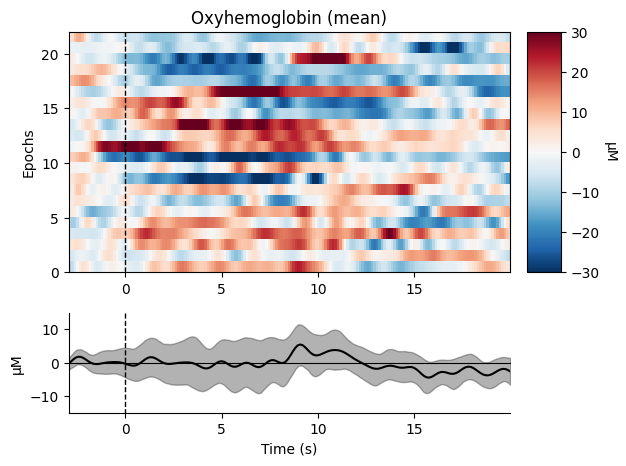

[<Figure size 640x480 with 3 Axes>]

In [82]:
hbo['rest'].copy().crop(-3,20).plot_image(combine='mean', vmin=-30, vmax=30,
                             ts_args=dict(ylim=dict(hbo=[-15, 15],
                                                    hbr=[-15, 15])))

Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


C:\Users\Alberto\AppData\Local\Temp\ipykernel_17928\1295706234.py:1: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.epochs.EpochsFIF'>.tmax (19.968 sec)
  hbr['rest'].copy().crop(-3,20).plot_image(combine='mean', vmin=-30, vmax=30,


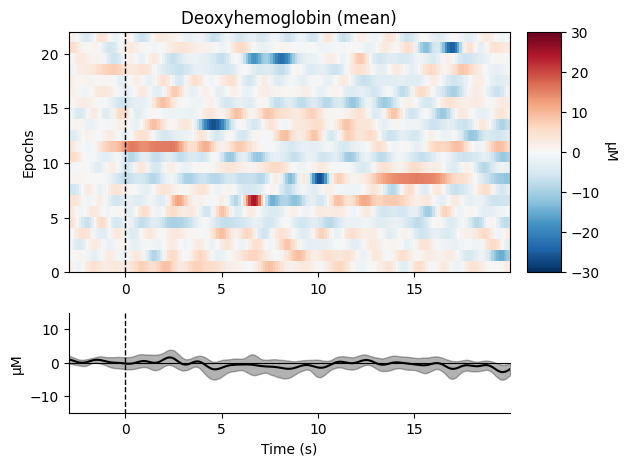

[<Figure size 640x480 with 3 Axes>]

In [83]:
hbr['rest'].copy().crop(-3,20).plot_image(combine='mean', vmin=-30, vmax=30,
                             ts_args=dict(ylim=dict(hbo=[-15, 15],
                                                    hbr=[-15, 15])))

In [84]:
hbo.save('hbo_epo.fif', overwrite=True)
hbr.save('hbr_epo.fif', overwrite=True)

Overwriting existing file.
Overwriting existing file.
